In [1]:
#from SLR import SLR
#from OLS import OLS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from abc import ABC, abstractmethod


In [2]:
class LR(ABC):
    def __init__(self):
        '''
        Abstract class for realization linear regression
        
        Attributes:
            _y          [np.array]:     dependet var
            _y_predict  [np.array]:     predicted dependet var
            _e          [np.array]:     errors of prediction
            _dataset    [pd.DataFrame]: data
            _R_2        [float]:        coeficient of Determination
        '''
        self._y = None
        self._y_predict = None
        self._y_avg = None
        self._e = None
        self._dataset = None
        self._R_2 = None

    def _Load_data_set(self, path:str)->None:
        '''
        
        Load dataset from csv to DataFrame object

        '''
        full_path = os.path.join(os.getcwd(), path)
        
        if not os.path.isfile(full_path):  # check is file with dataset exist
            raise Exception(f'Error! File with dataset on path "{path}" is not exist')
        
        self._dataset= pd.read_csv(full_path)  # store dataset to dataframe
        
        if self._dataset.empty:  # check is dataframe not empty
            raise Exception(f'Waring! Data set on path "{path}" is empty. Counting is aborted.')

    @abstractmethod
    def _Sampling(self)->None:
        '''
        Abstract method for choosing dependet and independet var from dataframe for analys
        '''
        pass

    @abstractmethod
    def Vizualization(self)->None:
        '''
        Abstract method for vizualization output
        '''
        pass

    
    def _Evaluation(self)->None:
        '''
        Evaluation of correlation between dependet/s and independet vars

                ERROR = Y - Y_predict
                R_2 = 1 - SS_res/SS_tos

        '''
        self._e = self._y - self._y_predict
        
        # residual sum of squares
        SS_res = np.sum(np.power(self._e, 2))
        # total sum of squares
        SS_tos = np.sum(np.power((self._y-self._y_avg), 2))

        # coeficient of Determination
        self._R_2 = 1 - SS_res/SS_tos
    
    @abstractmethod
    def _Linear_regression(self)->None:
        '''
        Abstarct method for searching linear regression
        '''
        pass

In [3]:
class SLR(LR):
    '''
    Class for implements a Simple Linear Regression(SLR)
    '''
    def __init__(self):
        '''
        _solution   [pd.Dataframe]:     outputs data of SLR model
        _eval       [pd.Dataframe]:     evaluation of SLR model
        _x_name     [str]:              name of column for independet data in input dataset
        _y_name     [str]:              name of column for dependet data in input dataset 
        _x          [np.array]:         independet var
        _x_avg      [np.array]:         average value of independet var
        _a          [float]:            alpha coeficient of SLR model (point on OY)
        _b          [float]:            betha  coeficient of SLR model (angle between OX and OY)
        _r          [float]:            correlation coeficient
        '''
        super().__init__()
        self._solution = pd.DataFrame(columns=['sample_size', 'Y', 'Pr Y', 'A', 'B'])
        self._eval = pd.DataFrame(columns=['E', 'X*E', 'r', 'R^2'])
        self._x_name = None
        self._y_name = None
        self._x = None
        self._x_avg = None
        self._a = None
        self._b = None
        self._r = None
        

    def _Sampling(self, test)->None:
        # check data
        if not self._x_name in self._dataset.columns:
            raise Exception(f'Column "{self._x_name}" is not exist in actual dataframe!')
        
        if not self._y_name in self._dataset.columns:
            raise Exception(f'Column "{self._y_name}" is not exist in actual dataframe!')
        
        
        if not pd.to_numeric(self._dataset[self._x_name], errors='coerce').notnull().all():
            raise Exception(f'Column "{self._x_name}" have literal values and can not be used in experiment!')
        
        if not pd.to_numeric(self._dataset[self._y_name], errors='coerce').notnull().all():
            raise Exception(f'Column "{self._y_name}" have literal values and can not be used in experiment!')

        # choose data
        if test:
            sample  = self._dataset.sample(n=100)
        else:
            sample = self._dataset.loc[:, [self._x_name, self._y_name]]
        self._x = sample[self._x_name].values
        self._y = sample[self._y_name].values
    
    def Vizualization(self, with_err:bool=False)->None:
        plt.scatter(self._x, self._y, marker='o', color='blue', label='data')  # original relation

        plt.axis([self._x.min()-10, self._x.max()+10, self._y.min()-10, self._y.max()+10])
        
        plt.plot(self._x, self._y_predict, color='red', label='prediction')  # prediction

        if with_err:  # viz relation between predicted and real Y
            point = 0
            lab = 'error'
            for x_it, y_it, y_pr_it, e_it in np.nditer([self._x, self._y, self._y_predict, self._e]):  # one time iteration on many np arrays
                point += 1
                plt.plot([x_it, x_it], [y_pr_it, y_pr_it+e_it], color='green', label=lab)  # e = y_real - y_predict
                lab=None
        plt.axhline(y=np.mean(self._y), color='black', linestyle='--', label='weight center')
        plt.axvline(x=np.mean(self._x), color='black', linestyle='--')

        plt.xlabel(self._x_name)
        plt.ylabel(self._y_name)
        plt.title('SLR')
        plt.legend()
        plt.show()

    def _Linear_regression(self)->None:
        '''
        Description:

        Y_PREDICT = a + b*X

        a = avg(Y) - b*X

                sum((X-avg(X))*(Y-avg(Y)))
        b = -------------------------
                sum((X-avg(X))**2)

        '''
        
        # avg of dependet and independet var
        self._x_avg = np.mean(self._x)
        self._y_avg = np.mean(self._y)

        # betha coeficient
        self._b = np.sum(np.multiply((self._x - self._x_avg), (self._y - self._y_avg)))/np.sum(np.power((self._x - self._x_avg), 2))
        # alpha coeficient
        self._a = self._y_avg - self._b*self._x_avg
        # prediction
        self._y_predict = self._a + self._b*self._x

    
    def _Evaluation(self)->tuple[float, float]:
        '''
        Evaluation of correlation between dependet and independet vars

                    avg(X*Y) - avg(X)*avg(Y)
                r = --------------------------
                    sqrt((avg(X**2)-avg(X)**2)*(avg(Y**2)-avg(Y)**2))

                R_2 = 1 - SS_res/SS_tos
    
        '''
        super()._Evaluation()
        # correlation coeficient
        self._r = (np.mean(np.multiply(self._x, self._y)) - self._x_avg*self._y_avg)/np.sqrt((np.mean(np.power(self._x,2))-self._x_avg**2)*(np.mean(np.power(self._y,2))-self._y_avg**2))
        
        

    def SLR(self, path:str, x_name:str, y_name:str, test=False)->None:
        '''
            Base method
        '''
        # clean old data
        self._solution.drop(self._solution.index,inplace=True)
        self._eval.drop(self._eval.index,inplace=True)
        # preparation
        self._x_name, self._y_name = x_name, y_name
        self._Load_data_set(path)
        self._Sampling(test)
        
        # SLR core
        self._Linear_regression()
        self._Evaluation()

        # save outputs data
        self._solution.loc[len(self._solution)] = {'sample_size':self._x.size, 'Y':np.sum(self._y), 'Pr Y':np.sum(self._y_predict), 'A': self._a, 'B': self._b}   # store output of actual expiriment
        self._eval.loc[len(self._eval)] = {'E':np.sum(self._e), 'X*E':np.sum(np.multiply(self._x, self._e)), 'r': self._r, 'R^2':self._R_2}
        
        print(self._solution)
        print(self._eval)


In [4]:

class OLS(LR):
    '''
    Class for implements a Simple Linear Regression(SLR)
    '''
    def __init__(self):
        '''
        _solution   [pd.Dataframe]:     outputs data of OLS model
        _eval       [pd.Dataframe]:     evaluation of OLS model
        _x_name     [List[str]]:        names of columns for independet data in input dataset
        _y_name     [str]:              name of column for dependet data in input dataset 
        _x          [2-D np.array]:     independet vars
        _B          [np.arrays]:        betha  coeficients of OLS model
        '''
        super().__init__()
        self._solution = pd.DataFrame(columns=['sample_size', 'Y', 'Pr Y'])
        self._eval = pd.DataFrame(columns=['E', 'R^2'])
        self._x = None
        self._x_names = None
        self._y_name = None
        self._B = None

    def _Sampling(self)->None:
        # check data
        for x_name in self._x_names:
            if x_name not in self._dataset.columns:
                 raise Exception(f'Column "{x_name}" is not exist in actual dataframe!')

        
        if self._y_name not in self._dataset.columns:
                raise Exception(f'Column "{self._y_name}" is not exist in actual dataframe!')

        for x_name in self._x_names:
            if not pd.to_numeric(self._dataset[x_name], errors='coerce').notnull().all():
                raise Exception(f'Column "{x_name}" have literal values and can not be used in experiment!')
        
        if not pd.to_numeric(self._dataset[self._y_name], errors='coerce').notnull().all():
            raise Exception(f'Column "{self._y_name}" have literal values and can not be used in experiment!')

        
        # choose data
        self._x = self._dataset[self._x_names].values
        self._y = self._dataset[self._y_name].values

    def Vizualization(self)->None:
        if len(self._x_names) != 2:
            raise Exception('Warning! 3D vizualization OLS is only for 2d X variables ')
        fig = plt.figure() 
        ax = fig.add_subplot(111, projection='3d') 
        ax.scatter(self._x[:, 1], self._x[:, 2], self._y, color='blue')  # real y
        X1, X2 = np.meshgrid(self._x[:, 1], self._x[:, 2])
        Y = self._B[0] + self._B[1]*X1 + self._B[2]*X2
        ax.plot_surface(X1, X2, Y, color='red', alpha=0.5)  # plane of independet X 
        ax.set_xlabel('X1') 
        ax.set_ylabel('X2') 
        ax.set_zlabel('Y') 
        plt.show()

    def _Evaluation(self)->None:
        super()._Evaluation()
        for i in range(self._x.shape[1]):
            x = self._x[:,i]
            print(f'E*X{i}: {np.sum(np.multiply(self._e, x))}')
    
    def _Linear_regression(self)->None:
        '''
        Ordinary least squere process
            b = ((X^T*X)^-1)*X^T*y
            Y = Xb
        '''
        # helpful calc
        self._y_avg = np.mean(self._y)
        ones_arr = np.ones(self._x.shape[0])
        self._x = np.column_stack((ones_arr, self._x))
        x_t = np.transpose(self._x)
        inv_x_t_mul_x =np.linalg.inv(np.dot(x_t,self._x))
        
        # correlation coeficient
        self._B = np.dot(np.dot(inv_x_t_mul_x, x_t), self._y)
        # prediction
        self._y_predict = np.dot(self._x, self._B)

        
    def OLS(self, path, x_names, y_name:str):
        '''
        Base method
        '''
        # clean old data
        self._solution.drop(self._solution.index, inplace=True)
        self._eval.drop(self._eval.index,inplace=True)
        
        # preparation
        self._x_names, self._y_name = x_names, y_name
        self._Load_data_set(path)
        self._Sampling()
        
        # OLS core
        self._Linear_regression()
        self._Evaluation()

        # save output
        self._solution.loc[len(self._solution)] = {'sample_size':self._y.size, 'Y':np.sum(self._y), 'Pr Y':np.sum(self._y_predict)}
        self._eval.loc[len(self._eval)] = {'E':np.sum(self._e), 'R^2':self._R_2}

        print(self._solution)
        print(self._eval)
        

In [5]:
# objects for Simple linear regression and Ordinary Least Squere

SLR_solution = SLR()
OLS_solution = OLS()



   sample_size              Y           Pr Y         A         B
0         2416  450351.220289  450351.220289 -0.280282  1.002216
              E           X*E         r       R^2
0 -4.543210e-11 -1.684748e-08  0.998886  0.997773


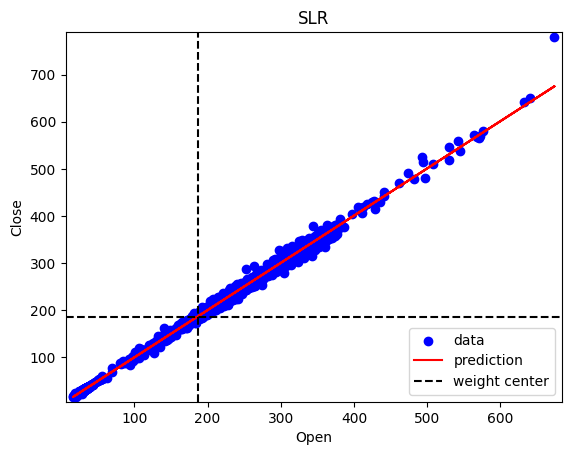

In [6]:
# Experiment № 1
# Description: SLR with ideal correlations model
SLR_solution.SLR('dataset/TSLA.csv', 'Open', 'Close')
SLR_solution.Vizualization()

   sample_size              Y           Pr Y         A         B
0         2416  450351.220289  450351.220289 -0.353225  0.985118
              E           X*E        r       R^2
0 -3.542766e-11 -3.754394e-09  0.99964  0.999281


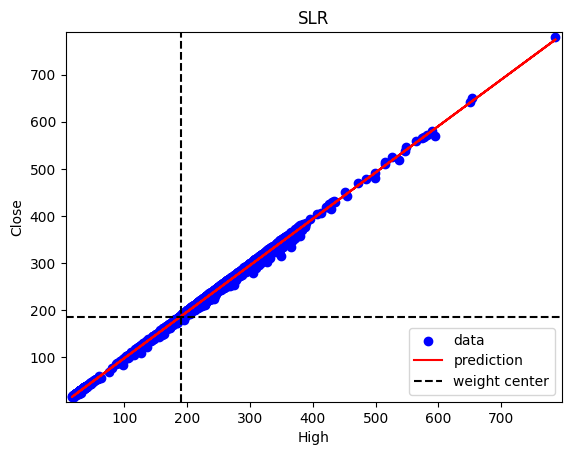

In [7]:
SLR_solution.SLR('dataset/TSLA.csv', 'High', 'Close')
SLR_solution.Vizualization()

   sample_size              Y           Pr Y         A         B
0         2416  450351.220289  450351.220289  0.023725  1.018934
              E           X*E         r       R^2
0  7.815970e-12  5.207312e-09  0.999447  0.998894


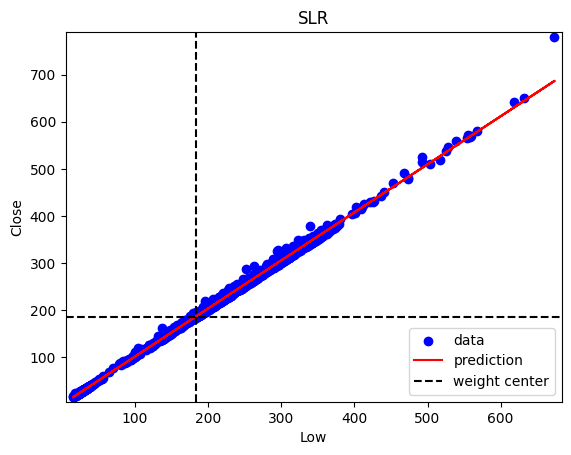

In [8]:
SLR_solution.SLR('dataset/TSLA.csv', 'Low', 'Close')
SLR_solution.Vizualization()

   sample_size       Y      Pr Y          A       B
0         2040  149092  149092.0  44.984073  0.2204
              E           X*E         r       R^2
0  3.694822e-12  2.801244e-10  0.756042  0.571599


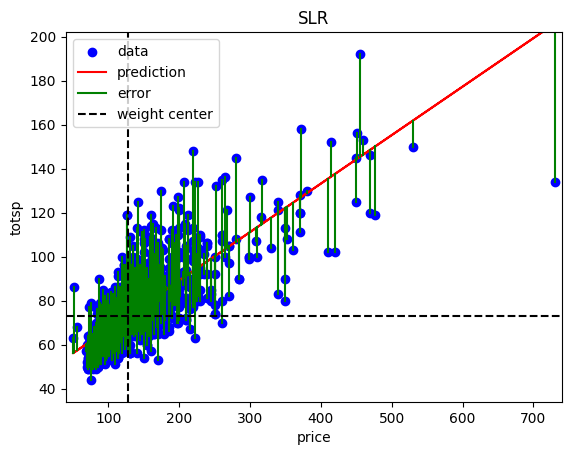

In [9]:
# Experiment № 2
# Description: SLR with bad correlations model
SLR_solution.SLR('dataset/flats.csv', 'price', 'totsp')
SLR_solution.Vizualization(True)

   sample_size       Y      Pr Y          A         B
0         2040  149092  149092.0  78.745091 -0.513883
              E           X*E         r       R^2
0  1.352873e-11  1.573426e-10 -0.114698  0.013156


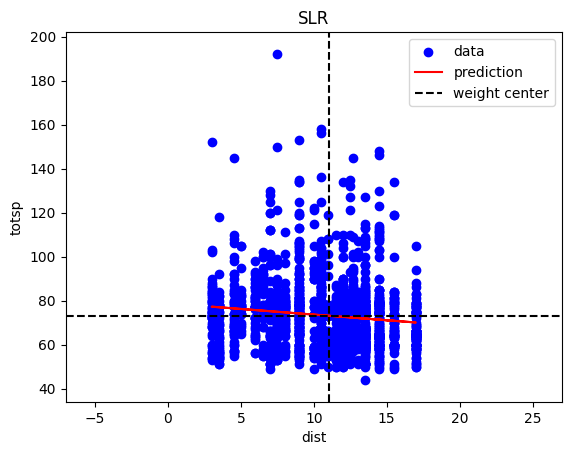

In [10]:
SLR_solution.SLR('dataset/flats.csv', 'dist', 'totsp')
SLR_solution.Vizualization()

   sample_size       Y      Pr Y         A         B
0         2040  149092  149092.0 -3.456116  1.651812
              E           X*E         r      R^2
0  8.753887e-12  3.810783e-10  0.862236  0.74345


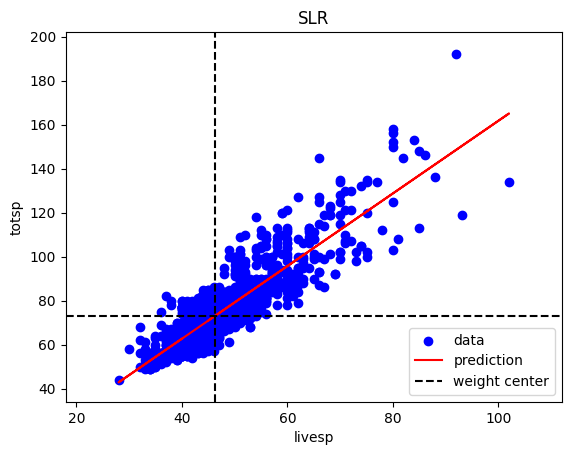

In [11]:
SLR_solution.SLR('dataset/flats.csv', 'livesp', 'totsp')
SLR_solution.Vizualization()

In [12]:
# Experiment № 3
# Description: OLR with good correlations model
OLS_solution.OLS('dataset/TSLA.csv', ['Open', 'Low', 'High'], 'Close' )


E*X0: -1.4147371985018253e-07
E*X1: -1.2609914847416803e-05
E*X2: -1.2373106073937379e-05
E*X3: -1.2802052879123949e-05
   sample_size              Y           Pr Y
0         2416  450351.220289  450351.220289
              E       R^2
0 -1.414737e-07  0.999709


In [13]:
# Experiment № 4
# Description: OLR with bad correlations model
OLS_solution.OLS('dataset/flats.csv', ['price', 'livesp', 'dist'], 'totsp')

E*X0: -6.983214007050265e-11
E*X1: 6.92307366989553e-09
E*X2: -6.430127541534603e-10
E*X3: -6.618847692152485e-10
   sample_size       Y      Pr Y
0         2040  149092  149092.0
              E       R^2
0 -6.983214e-11  0.790664


In [14]:
# Experiment № 4
# Description: OLR 3D vizualization
OLS_solution.OLS('dataset/TSLA.csv', ['Open', 'High'], 'Close' )

E*X0: 6.79991387642076e-08
E*X1: -4.781821189681068e-06
E*X2: -4.80757444165647e-06
   sample_size              Y           Pr Y
0         2416  450351.220289  450351.220289
              E       R^2
0  6.799914e-08  0.999309


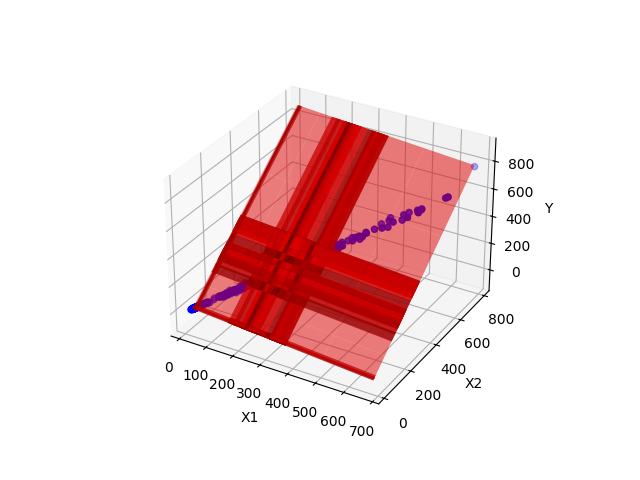

In [15]:
%matplotlib widget
OLS_solution.Vizualization()